In [96]:
import numpy as np
import matplotlib.pyplot as plt

Classe Boite

In [97]:
class Boite():
    def __init__(self):
        pass
    def forward (self,inputs):
        self.inputs=inputs
        self.output=self.operation()
        return self.output
    def backward (self,derive_output):
        self.derive_output=derive_output
        assert self.derive_output.shape==self.output.shape,f"La derivée outputs a un shape{self.derive_output.shape}et different du shape de output {self.output.shape}"
        self.derive_inputs=self.gradient(derive_output)
        assert self.derive_inputs.shape==self.inputs.shape,f"La derivée inputs a un shape{self.derive_inputs.shape}et different du shape de input {self.inputs.shape}"
        return self.derive_inputs
    def operation (self):
        pass
    def gradient (self,derive_output):
        pass

Classe Boite parametréee

In [98]:
class BoiteParams():
    def __init__(self,params):
        self.params=params

    def forward (self,inputs):
        self.inputs=inputs
        self.output=self.operation()
        return self.output
    
    def backward (self,derive_output):
        self.derive_output=derive_output
        # assert self.derive_output.shape==self.output.shape,f"La derivée outputs a un shape{self.derive_output.shape}et different du shape de output {self.output.shape}"
        #Derivee par rapport a l'input
        self.derive_inputs=self.gradient(derive_output)
        #assert self.derive_inputs.shape==self.inputs.shape,f"La derivée inputs a un shape{self.derive_inputs.shape}et different du shape de input {self.inputs.shape}"
        #Derivee par rapport au param
        self.derive_params=self.gradient_params(derive_output)
        #assert self.derive_params.shape==self.params.shape,f"La derivée params a un shape{self.derive_params.shape}et different du shape de params {self.params.shape}"
        return self.derive_inputs
    
    def operation (self):
        pass
    def gradient (self,derive_output):
        pass
    def gradient_params(self,derive_output):
        pass

Classe Dot

In [99]:
class Dot(BoiteParams):
    def __init__(self, weights):
        super().__init__(weights)

    def operation(self):
        return np.dot(self.inputs,self.params)
    def gradient(self,derive_output):
        return np.dot(derive_output,self.params.T)
    def gradient_params(self,derive_output):
        return np.dot(self.inputs.T,derive_output)
    def __repr__(self):
        return "Produit Matriciel"

Classe Ajout biais

In [100]:
class Add(BoiteParams):
    def __init__(self, biais):
        super().__init__(biais)

    def operation(self):
        return self.inputs+self.params
    def gradient(self,derive_output):
        return np.ones_like(self.inputs)*derive_output
    def gradient_params(self,derive_output):
        r=np.ones_like(self.params)*derive_output
        return r.sum(axis=0).reshape(1,self.params.shape[1])
    def __repr__(self):
        return "Ajout Biais"

Class Sigmoid

In [101]:
class Sigmoid(Boite):
    def __init__(self):
        super().__init__()

    def operation(self):
        return 1/(1+np.exp(-1*self.inputs))
    def gradient(self,derive_output):
        return self.output*(1-self.output)*derive_output
    
    def __repr__(self):
        return "Sigmoid"

Class Loss

In [102]:
class Loss:
    def __init__(self):
        pass
    def forward(self,prediction,target):
        #assert prediction.shape==target,f"{prediction.shape}=! {target.shape}"
        self.prediction=prediction
        self.target=target
        loss=np.mean((self.target-self.prediction)**2)
        return loss
    def backward (self):
        self.loss_derivee=-2*(self.target-self.prediction)
        #assert self.loss_derivee.shape==self.prediction.shape
        return self.loss_derivee

Classe Dense

In [103]:
class Dense:
    def __init__(self,neurons,activation=None):
        self.neurons=neurons
        self.activation=activation
        self.params=[]
        self.suite=[]
        self.initialisation=True
        self.derivee_params=[]
    
    def build(self,inputs):
        
        #Weights initialization
        self.weights=np.random.randn(inputs.shape[1],self.neurons)
        self.biais=np.random.randn(1,self.neurons)
        self.params.append(self.weights)
        self.params.append(self.biais)

        #Suite d'operations

        self.suite=[Dot(weights=self.params[0]),Add(biais=self.params[1])]
        if self.activation:
            self.suite.append(self.activation)

    
    def forward(self,inputs):
        if self.initialisation:
            self.initialisation=False
            self.build(inputs)
            

        for boite in self.suite:
            inputs=boite.forward(inputs)
            self.output=inputs
        return self.output
       

    def backward(self,derivee_output):
      #assert derivee_output.shape==self.output.shape
      for boite in reversed(self.suite):
          derivee_output=boite.backward(derivee_output)
      derivee_inputs=derivee_output
      assert derivee_output.shape==derivee_inputs.shape
      self.get_layer_gradients()
      return derivee_inputs
      

    def get_layer_gradients(self):
        for boite in self.suite:
            if issubclass(boite.__class__, BoiteParams):
                self.derivee_params.append(boite.derive_params)
        return(boite)
    

    """def update_params(self, learning_rate):
        for param, derivee_param in zip(self.params, self.derivee_params):
            param -= learning_rate * derivee_param
        self.params=param
        return self.params """

      
    def __repr__(self):
        r=f"Dense Layer(neurons={self.neurons})"
        if self.activation:
            r+=f" Avec Sigmoid{self.initialisation}"
        return r


Classe Modele()

In [104]:
class Modele():
    def __init__(self,layers):
        self.layers=layers
        
    def forward(self,inputs):
        for layer in self.layers:
            inputs=layer.forward(inputs)    
        self.output=inputs 
        return self.output
    
    def backward(self, loss_derivee):
        for layer in reversed(self.layers):
            loss_derivee = layer.backward(loss_derivee)
        return loss_derivee

    def get_params(self):
        self.params=[]
        for layer in self.layers:
            self.params.append(layer.params)
        return self.params
    
    def get_derivee_params(self):
        self.derivee_params=[]
        for layer in self.layers:
            self.derivee_params.append(layer.derivee_params)
        return self.derivee_params
    
    def update(self,learning_rate):
        params = self.get_params()
        derivee_params = self.get_derivee_params()

        for layer_params, layer_derivee_params in zip(params, derivee_params):
            for param, derivee_param in zip(layer_params, layer_derivee_params):
                param -= learning_rate * derivee_param
        return self.params
    
    def compile(self,learning_rate=0.01):
        self.mse=Loss()
        self.learning_rate=learning_rate
        return self.mse
    
    def fit(self,X,Y,epochs:int):
        self.Loss=[]
        for i in range(epochs):
            mse=self.compile()
            P=self.forward(inputs=X)
            loss=self.mse.forward(P,Y)
            self.Loss.append(loss)
            print("Epoch",i+1,"----------- Loss=",loss)
            loss_derivee=self.mse.backward()
            self.backward(loss_derivee=loss_derivee)
            self.update(learning_rate=self.learning_rate)
        return self.Loss
    
    def learnig_curve(self):
        plt.plot(self.Loss)


    def __repr__(self):
        r="Layers ..............."
        for layer in self.layers:   
            r+=f"\n {str(layer)}"
        return r


In [105]:
np.random.seed(42)
X=np.random.randn(4,3)
Y=np.random.randn(4,1)

In [106]:
model=Modele([Dense(neurons=3,activation=Sigmoid()),Dense(1)])

In [107]:
model.compile()

In [108]:
l=model.fit(X,Y,10)

Epoch 1 ----------- Loss= 6.242609775094623
Epoch 2 ----------- Loss= 5.065739119414946
Epoch 3 ----------- Loss= 4.021504812707027
Epoch 4 ----------- Loss= 3.1149029563139896
Epoch 5 ----------- Loss= 2.351107807084233
Epoch 6 ----------- Loss= 1.7354609465152544
Epoch 7 ----------- Loss= 1.273457903371753
Epoch 8 ----------- Loss= 0.9707322648286854
Epoch 9 ----------- Loss= 0.8330373850723083
Epoch 10 ----------- Loss= 0.8662258769069964


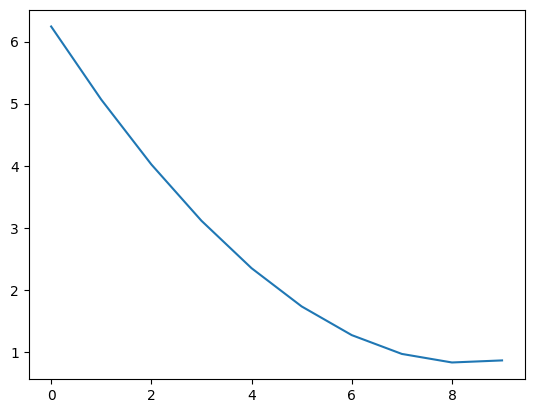

In [109]:
model.learnig_curve()

Test  sur un dataset

In [110]:
from sklearn.datasets import load_iris
dataset=load_iris()
X=dataset.data
y=dataset.target
y=y.reshape(y.shape[0],1)

In [111]:
model=Modele([Dense(neurons=7,activation=Sigmoid()),Dense(1,activation=Sigmoid())])

In [112]:
model.compile(learning_rate=0.00001)

In [113]:
l=model.fit(X,y,55)

Epoch 1 ----------- Loss= 1.2814551379921673
Epoch 2 ----------- Loss= 0.6656245877874667
Epoch 3 ----------- Loss= 0.6470467351023519
Epoch 4 ----------- Loss= 0.6617665271037272
Epoch 5 ----------- Loss= 0.6658329200639256
Epoch 6 ----------- Loss= 0.6665444701537824
Epoch 7 ----------- Loss= 0.6666498902356393
Epoch 8 ----------- Loss= 0.666664407151859
Epoch 9 ----------- Loss= 0.6666663583745123
Epoch 10 ----------- Loss= 0.6666666229538962
Epoch 11 ----------- Loss= 0.666666660097818
Epoch 12 ----------- Loss= 0.6666666656093189
Epoch 13 ----------- Loss= 0.6666666664845718
Epoch 14 ----------- Loss= 0.6666666666334824
Epoch 15 ----------- Loss= 0.6666666666603649
Epoch 16 ----------- Loss= 0.6666666666654373
Epoch 17 ----------- Loss= 0.666666666666423
Epoch 18 ----------- Loss= 0.666666666666618
Epoch 19 ----------- Loss= 0.666666666666657
Epoch 20 ----------- Loss= 0.6666666666666646
Epoch 21 ----------- Loss= 0.6666666666666664
Epoch 22 ----------- Loss= 0.6666666666666665
Ep

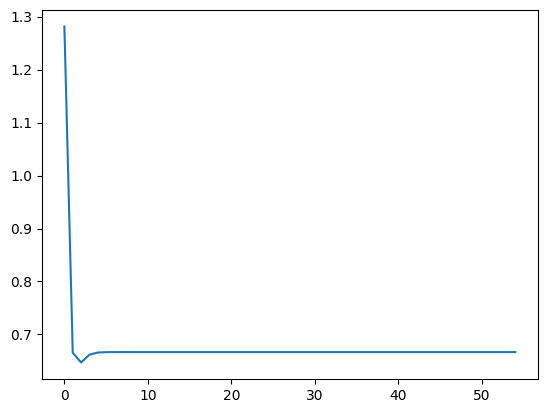

In [114]:
model.learnig_curve()